In [1]:
# 导入相关库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 导入数据集，从 CSV 文件中加载数据

dataset = pd.read_csv('Wine.csv') 
X = dataset.iloc[:, 0:13].values # 取出所有行，列为 0 到 12 的数据
y = dataset.iloc[:, 13].values # 取出所有行，列为 13 的数据

In [3]:
# 将数据集分割为训练集和测试集
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    X_train = X[indices[test_size:]]
    y_train = y[indices[test_size:]]
    X_test = X[indices[:test_size]]
    y_test = y[indices[:test_size]]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [4]:
# 特征缩放，对特征进行标准化处理
def standard_scaler(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)

In [5]:
# 计算类内散布矩阵
def within_class_scatter_matrix(X_train_scaled, y_train):
    class_labels = np.unique(y_train)
    S_W = np.zeros((X_train_scaled.shape[1], X_train_scaled.shape[1]))
    for label in class_labels:
        X_class = X_train_scaled[y_train == label]
        mean = np.mean(X_class, axis=0)
        deviation = X_class - mean
        S_W += np.dot(deviation.T, deviation)
    return S_W

In [6]:
# 计算类间散布矩阵
def between_class_scatter_matrix(X_train_scaled, y_train):
    class_labels = np.unique(y_train)
    mean_all = np.mean(X_train_scaled, axis=0)
    S_B = np.zeros((X_train_scaled.shape[1], X_train_scaled.shape[1]))
    for label in class_labels:
        X_class = X_train_scaled[y_train == label]
        mean = np.mean(X_class, axis=0)
        n = X_class.shape[0]
        deviation = mean - mean_all
        S_B += n * np.outer(deviation, deviation)
    return S_B

In [7]:
# 计算特征值和特征向量
def compute_eigen(S_W, S_B):
    eigen_values, eigen_vectors = np.linalg.eigh(np.linalg.inv(S_W).dot(S_B))
    return eigen_values, eigen_vectors


In [8]:
# 选择前 k 个特征向量
def select_top_k(eigen_values, eigen_vectors, k):
    eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
    eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
    return np.array([pair[1] for pair in eigen_pairs[:k]])

In [9]:
# 计算投影后的数据
def project_data(X, W):
    return X.dot(W.T)

In [10]:
# 计算类内散布矩阵和类间散布矩阵
S_W = within_class_scatter_matrix(X_train_scaled, y_train)
S_B = between_class_scatter_matrix(X_train_scaled, y_train)

# 计算特征值和特征向量
eigen_values, eigen_vectors = compute_eigen(S_W, S_B)

# 选择前 k 个特征向量
k = 2
W = select_top_k(eigen_values, eigen_vectors, k)

# 投影训练集和测试集
X_train_lda = project_data(X_train_scaled, W)
X_test_lda = project_data(X_test_scaled, W)

In [11]:
# 将逻辑回归模型拟合到训练集上
class LogisticRegressionMulticlass:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.biases = None
        self.num_classes = None
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.num_classes = len(np.unique(y))
        self.weights = np.zeros((num_features, self.num_classes))
        self.biases = np.zeros(self.num_classes)
        
        # 将类别索引减去 1，以使其从 0 开始
        y -= 1
        
        # 将类别转换为 one-hot 编码
        y_one_hot = np.eye(self.num_classes)[y]
        
        # 梯度下降训练模型
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.biases
            y_predicted = self.softmax(linear_model)
            
            # 计算梯度
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y_one_hot))
            db = (1 / num_samples) * np.sum(y_predicted - y_one_hot, axis=0)
            
            # 更新权重和偏差
            self.weights -= self.learning_rate * dw
            self.biases -= self.learning_rate * db
    
    def predict(self, X):
        linear_models = np.dot(X, self.weights) + self.biases
        y_predicted_probs = self.softmax(linear_models)
        y_predicted_classes = np.argmax(y_predicted_probs, axis=1)  # 对每个样本预测概率最大的类别
        return y_predicted_classes


# 使用 LDA 进行降维后的训练集和测试集
classifier = LogisticRegressionMulticlass()
classifier.fit(X_train_lda, y_train)
y_pred = classifier.predict(X_test_lda)

np.savetxt('y_pred.csv', y_pred, delimiter=',')


# 将逻辑回归模型拟合到训练集上
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(random_state = 0)
classifier1.fit(X_train_lda, y_train)
# 使用模型对测试集进行预测
y_pred1 = classifier1.predict(X_test_lda)
np.savetxt('y_pred1.csv', y_pred1, delimiter=',')

In [12]:
# 计算混淆矩阵，用于评估分类准确度
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

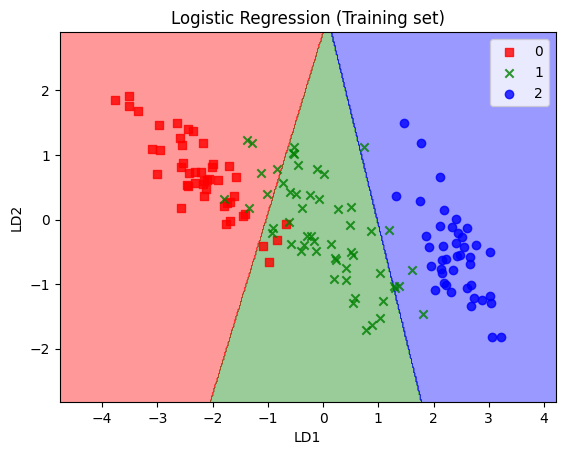

In [13]:
# 可视化训练集结果，绘制分类边界
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o')
    colors = ('red', 'green', 'blue')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # 使用分类器对每个点进行预测
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # 绘制等高线图
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 绘制样本点
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[cmap(idx)], marker=markers[idx], label=cl)

# 绘制分类边界
plot_decision_regions(X_train_lda, y_train, classifier)
plt.title('Logistic Regression (Training set)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

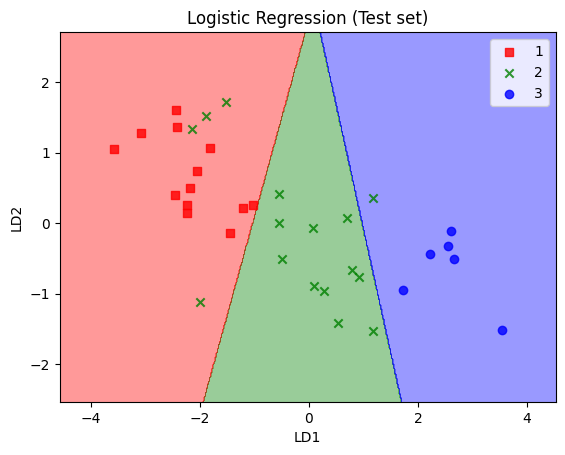

In [14]:
# 可视化测试集结果，绘制分类边界
plot_decision_regions(X_test_lda, y_test, classifier)
plt.title('Logistic Regression (Test set)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()